<a href="https://colab.research.google.com/github/MayerT1/Sewanee_Colab/blob/main/Salinity/Copy_of_Gaussian_processes_Dev_SC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyproj shapely geopandas


In [ ]:
!pip install pymc arviz numpy pandas matplotlib scikit-learn


In [ ]:
!pip install folium



In [ ]:
import folium

# 1. Create Map
m = folium.Map(location=[32.32469873783004, -80.5093231324689], zoom_start=10)

# 2. Define Bounding Box [South-West, North-East]
la_bbox = [[32.32469873783004, -80.5093231324689], [32.866166995153854, -79.7897186402814]]

# 3. Add Rectangle
folium.Rectangle(bounds=la_bbox, color='blue', fill=True).add_to(m)

# 4. Fit map to bounds
m.fit_bounds(la_bbox)

# Display in Colab
m

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

np.random.seed(42)

# ----------------------------
# 1. Projected bounds (meters)
# ----------------------------
xmin = 546183.2209589526
xmax = 613233.3129526969
ymin = 3576532.7666753773
ymax = 3637099.4310219567

# ----------------------------
# 2. Sample manageable number of sites
# ----------------------------
N = 68     # number of sites for GP model
K = 2      # number of covariates

coords = np.column_stack([
    np.random.uniform(xmin, xmax, N),
    np.random.uniform(ymin, ymax, N)
])

# Optional but recommended: scale coordinates for GP stability
coords_scaled = (coords - coords.mean(axis=0)) / coords.std(axis=0)

# ----------------------------
# 3. Covariates
# ----------------------------

# Use real spatial center of bounding box
feature_center = np.array([[(xmin + xmax)/2, (ymin + ymax)/2]])

distance = cdist(coords, feature_center).flatten()

percent_overlap = np.random.beta(2, 5, size=N)

X_raw = np.column_stack([distance, percent_overlap])

scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# ----------------------------
# 4. Simulate spatial GP field
# ----------------------------

def rbf_kernel(X1, X2, lengthscale=0.5, variance=1.0):
    dists = cdist(X1, X2)
    return variance * np.exp(-(dists**2) / (2 * lengthscale**2))

K_matrix = rbf_kernel(coords_scaled, coords_scaled)
K_matrix += 1e-6 * np.eye(N)

f = np.random.multivariate_normal(mean=np.zeros(N), cov=K_matrix)

# ----------------------------
# 5. True regression coefficients
# ----------------------------

beta_true = np.array([-1.0, 1.5])

logit_psi = X @ beta_true + f

psi = 1 / (1 + np.exp(-logit_psi))

y = np.random.binomial(1, psi)

# ----------------------------
# 6. Output
# ----------------------------

print("coords shape:", coords.shape)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Prevalence:", y.mean())


coords shape: (68, 2)
X shape: (68, 2)
y shape: (68,)
Prevalence: 0.47058823529411764


In [ ]:
# import numpy as np
# from pyproj import Transformer

# # ----------------------------
# # 1. Bounding box in lat/long
# # ----------------------------

# west  = -80.5093231324689
# east  = -79.7897186402814
# south = 32.32469873783004
# north = 32.866166995153854

# # ----------------------------
# # 2. Project to UTM (meters)
# # ----------------------------

# transformer = Transformer.from_crs("EPSG:4326", "EPSG:32617", always_xy=True)

# xmin, ymin = transformer.transform(west, south)
# xmax, ymax = transformer.transform(east, north)

# print("Projected bounds (meters):")
# print(xmin, xmax)
# print(ymin, ymax)

# # ----------------------------
# # 3. Create 10-meter grid
# # ----------------------------

# resolution = 10  # 10 meters

# x_coords = np.arange(xmin, xmax, resolution)
# y_coords = np.arange(ymin, ymax, resolution)

# xx, yy = np.meshgrid(x_coords, y_coords)

# coords = np.column_stack([xx.ravel(), yy.ravel()])

# print("coords shape:", coords.shape)


Projected bounds (meters):
546183.2209589526 613233.3129526969
3576532.7666753773 3637099.4310219567
coords shape: (40618242, 2)


In [ ]:
import pymc as pm
import numpy as np
import arviz as az

# Assume you already loaded:
# coords, X, y

N, K = X.shape

with pm.Model() as gp_occupancy:

    # Priors for regression
    beta = pm.Normal("beta", mu=0, sigma=1, shape=K)

    # GP hyperparameters
    ℓ = pm.HalfNormal("lengthscale", sigma=1.0)
    η = pm.HalfNormal("eta", sigma=1.0)

    # Covariance function (Matern 3/2 recommended)
    cov_func = η**2 * pm.gp.cov.Matern32(2, ℓ)

    gp = pm.gp.Latent(cov_func=cov_func)

    f = gp.prior("f", X=coords)

    # Linear predictor
    logit_psi = pm.math.dot(X, beta) + f

    psi = pm.Deterministic("psi", pm.math.sigmoid(logit_psi))

    # Occupancy likelihood
    y_obs = pm.Bernoulli("y_obs", p=psi, observed=y)

    trace = pm.sample(1000, tune=1000, target_accept=0.9)


Output()

ERROR:pymc.stats.convergence:There were 83 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'eta'}>, <Axes: title={'center': 'eta'}>],
       [<Axes: title={'center': 'f'}>, <Axes: title={'center': 'f'}>],
       [<Axes: title={'center': 'f_rotated_'}>,
        <Axes: title={'center': 'f_rotated_'}>],
       [<Axes: title={'center': 'lengthscale'}>,
        <Axes: title={'center': 'lengthscale'}>],
       [<Axes: title={'center': 'psi'}>, <Axes: title={'center': 'psi'}>]],
      dtype=object)

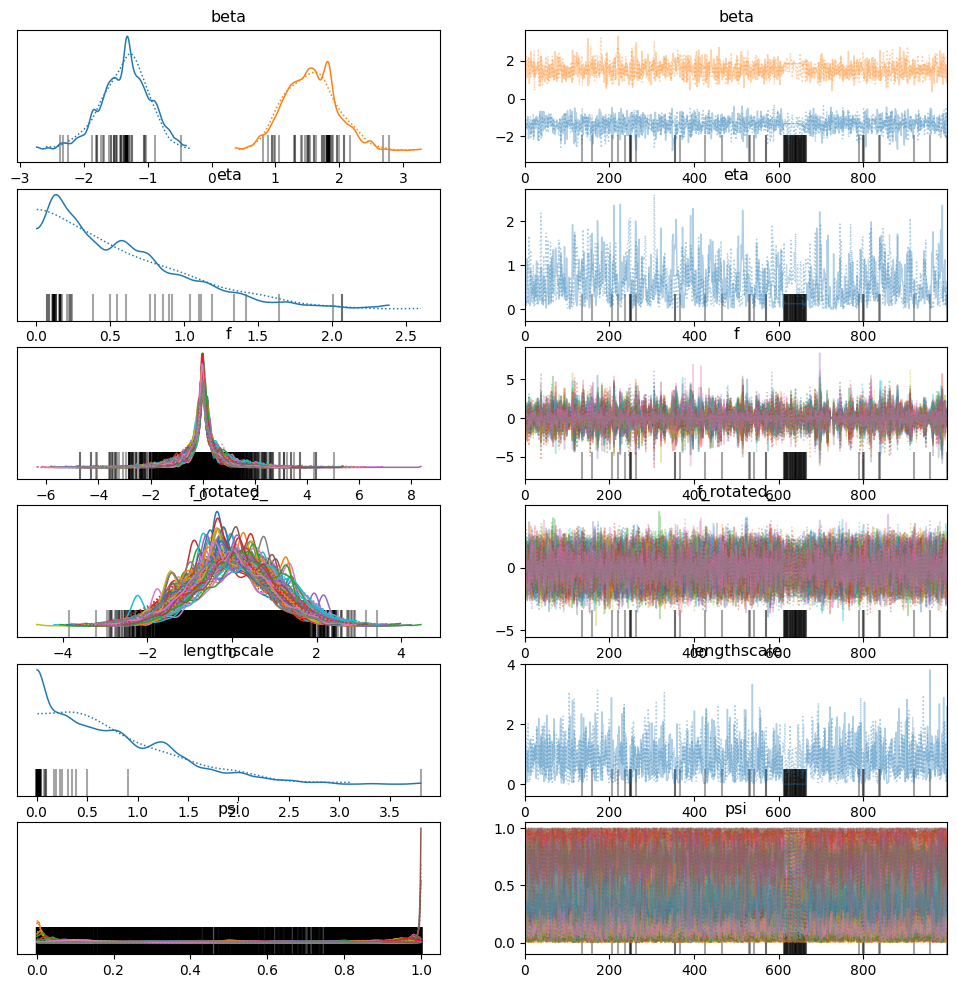

In [ ]:
az.summary(trace)
az.plot_trace(trace)


In [ ]:
# Create prediction grid
grid_size = 40

x_range = np.linspace(coords[:,0].min(), coords[:,0].max(), grid_size)
y_range = np.linspace(coords[:,1].min(), coords[:,1].max(), grid_size)

xx, yy = np.meshgrid(x_range, y_range)

grid_coords = np.column_stack([xx.ravel(), yy.ravel()])

print(grid_coords.shape)   # should be (grid_size^2, 2)


(1600, 2)


In [ ]:
with gp_occupancy:

    f_pred = gp.conditional("f_pred", Xnew=grid_coords)

    pred_samples = pm.sample_posterior_predictive(
        trace,
        var_names=["f_pred"]
    )


Output()